# -----------------------------------------------测试训练好的模型------------------------------

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import os
from PIL import Image
import import_ipynb

from torchvision import transforms

from Bulid_Vocab_2 import Vocabulary
from Model_4 import EncoderCNN, DecoderRNN

In [6]:
"""使用gpu"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
"""定义方法加载需要描述的图片"""
def load_image(image_path, transform=None):
    # 打开图片
    image = Image.open(image_path).convert('RGB')
    ## 将图片调整为224*224大小，和训练的一样大小
    image = image.resize([224, 224], Image.Resampling.LANCZOS)
    
    # 判断是否需要进行转变，是需要转成tensor的
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    # 返回处理好的图像
    return image

In [53]:
"""定义图片的处理形式"""
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [54]:
"""加载词表"""
with open('data/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

In [68]:
"""搭建模型"""
# 搭建编码器，并设置为验证模型
encoder = EncoderCNN(256).eval()
decoder = DecoderRNN(256, 512, len(vocab), 1)
# 将模型转移到gpu中
encoder = encoder.to(device)
decoder = decoder.to(device)

In [69]:
"""加载已经训练好的模型权重"""
encoder.load_state_dict(torch.load('models/encoder-5-3000.pkl'))
decoder.load_state_dict(torch.load('models/decoder-5-3000.pkl'))

<All keys matched successfully>

In [70]:
"""加载一个待描述的图像"""
image = load_image('png/a.png', transform)
image_tensor = image.to(device)

In [71]:
"""生成图像描述"""
# 计算图像特征向量
feature = encoder(image_tensor)
# 调用解码器的sample方法，生成描述的词元对应的序号
sampled_ids = decoder.sample(feature)
# 将结果转换为到cpu和numpy格式
sampled_ids = sampled_ids[0].cpu().numpy()

<start> a man holding a cell phone in front of a window . <end>


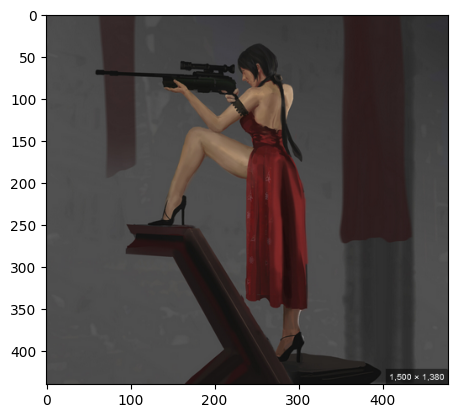

In [73]:
"""转换序号到词元，生成句子"""
sampled_caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    # 判断如果出现停止符，则停止输出
    if word == '<end>':
        break
# 加入空格在词元间
sentence = ' '.join(sampled_caption)

# 打印描述，并显示图像
print(sentence)
image = Image.open('png/a.png')
plt.imshow(np.asarray(image))